In [121]:
import pandas as pd
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import ttest_ind, f_oneway
import time
from dotenv import load_dotenv


In [70]:
# Set up the date range for the year
idx = pd.date_range(start='2023-01-01', end='2025-12-31', freq="h")

In [71]:
# Set a random seed for reproducibility
rng = np.random.default_rng(seed=42)

In [72]:
# Define the average wait times in minutes
mean_wait_time = 60

In [73]:
# Create a sine curve to reflect the changing average wait times throughout the day
# Simulate lower wait times during early morning and late night, higher in afternoon and evening
x = np.linspace(-np.pi, np.pi, 24)
means = (np.sin(x) * (mean_wait_time / 3)) + mean_wait_time

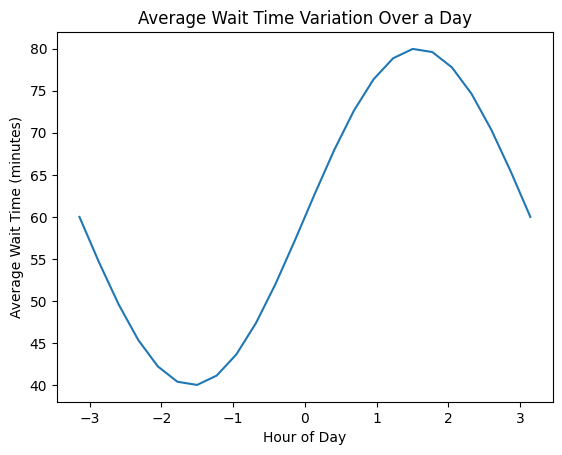

In [74]:
# Plot to visualize the average wait time pattern over a 24-hour period
plt.plot(x, means)
plt.title("Average Wait Time Variation Over a Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Wait Time (minutes)")
plt.show()

In [75]:
# Expanded the sine wave pattern to match the total number of data points in hours
number_of_days = len(idx) / 24
multiplier = (number_of_days * 2) - 1
x_extended = np.linspace(-np.pi, multiplier * np.pi, len(idx))
wait_time_means = (np.sin(x_extended) * (mean_wait_time / 3)) + mean_wait_time

In [76]:
# Generate wait times based on the Poisson distribution
df = pd.DataFrame(index=idx, data=rng.poisson(lam=wait_time_means, size=len(idx)), columns=["wait_time_minutes"])

In [ ]:
# OpenWeatherMap API key 
API_KEY = os.getenv('OPENWEATHER_API_KEY')
BASE_URL = 'https://api.openweathermap.org/data/2.5/weather'
latitude = 53.2707  # Galway latitude
longitude = -9.0568  # Galway longitude

print(f"API Key: {API_KEY}")  # This should print your key (only for debugging; avoid printing it in production)

load_dotenv()  # Load variables from the .env file
API_KEY = os.getenv('OPENWEATHER_API_KEY')
if not API_KEY:
    raise ValueError("API key not found. Please set the OPENWEATHER_API_KEY environment variable.")

# Set up the date range for the year (daily frequency)
idx = pd.date_range(start='2023-01-01', end='2023-12-31', freq="D")

# CSV cache file to save weather data
csv_cache_filename = 'weather_cache_daily.csv'

# Load CSV cache if exists
if os.path.exists(csv_cache_filename):
    weather_cache = pd.read_csv(csv_cache_filename, index_col='date', parse_dates=True)
else:
    weather_cache = pd.DataFrame(columns=['temperature', 'humidity', 'weather_condition'])

# Function to fetch weather data for a given city (current weather)
def get_weather_data(lat, lon):
    params = {
        'lat': lat,
        'lon': lon,
        'appid': API_KEY,
        'units': 'metric'
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Failed to fetch weather data. Status code: {response.status_code}")
        return None

# Loop through each day to fetch weather data
weather_features = []

for day in idx:
    # Check if data for this day is already in cache
    if day in weather_cache.index:
        # Fetch from cache
        temp = weather_cache.loc[day, 'temperature']
        humidity = weather_cache.loc[day, 'humidity']
        condition = weather_cache.loc[day, 'weather_condition']
    else:
        # Get weather data for the given location (use current weather)
        weather_data = get_weather_data(latitude, longitude)

        if weather_data:
            # Extract temperature, humidity, and weather condition
            temp = weather_data['main']['temp']
            humidity = weather_data['main']['humidity']
            condition = weather_data['weather'][0]['main']

            # Add the new data to the cache DataFrame
            new_data = pd.DataFrame({
                'temperature': [temp],
                'humidity': [humidity],
                'weather_condition': [condition]
            }, index=[day])
            
            # Only concatenate if new_data is not empty
            if not new_data.empty:
                weather_cache = pd.concat([weather_cache, new_data])

        else:
            temp, humidity, condition = None, None, None  # Handle missing data

        # Add a delay to avoid API rate limits
        time.sleep(1)  # 1-second delay between requests to respect rate limits

    weather_features.append([temp, humidity, condition])

# Create a DataFrame with weather data
weather_df = pd.DataFrame(weather_features, columns=['temperature', 'humidity', 'weather_condition'], index=idx)

# Merge weather data with your existing dataset
df = pd.concat([df, weather_df.reindex(df.index, method='ffill')], axis=1)

# Save cache to CSV for future use
weather_cache.to_csv(csv_cache_filename)

# Preview the updated DataFrame
print(df.head())

# Save to CSV for future use
df.to_csv('wait_times_with_weather.csv', index=True)

# plotting code here
df['temperature'].plot(title='Temperature Over Time')
plt.show()
df['humidity'].plot(title='Humidity Over Time')
plt.show()

# Plot the temperature trend over time
df['temperature'].plot(title='Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

# Plot the humidity trend over time
df['humidity'].plot(title='Humidity Over Time', color='orange')
plt.xlabel('Time')
plt.ylabel('Humidity (%)')
plt.grid(True)
plt.show()


In [77]:
# Feature for the day of the week
df['day_of_week'] = df.index.day_name()

In [80]:
# Seasonality Feature
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

df['season'] = df.index.month.map(get_season)

# Print counts to verify if all seasons are represented
season_counts = df['season'].value_counts()
print("\nData Points per Season after reassignment:")
print(season_counts)

# Check that the data range includes months for each season:
print(f"Data Range Start: {df.index.min()}")
print(f"Data Range End: {df.index.max()}")
print(f"Unique Months in Data: {df.index.month.unique()}")

# Additional Debugging to Check Representation
for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    count = df[df['season'] == season].shape[0]
    print(f"Data Points in {season}: {count}")

# If certain seasons are missing or underrepresented, consider rebalancing
missing_seasons = [season for season in ['Winter', 'Spring', 'Summer', 'Autumn'] if df[df['season'] == season].shape[0] == 0]
if missing_seasons:
    print(f"\nWarning: The following seasons are missing or underrepresented: {missing_seasons}")


Data Points per Season after reassignment:
season
Spring    6624
Summer    6624
Autumn    6552
Winter    6481
Name: count, dtype: int64
Data Range Start: 2023-01-01 00:00:00
Data Range End: 2025-12-31 00:00:00
Unique Months in Data: Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int32')
Data Points in Winter: 6481
Data Points in Spring: 6624
Data Points in Summer: 6624
Data Points in Autumn: 6552


In [81]:
# Holiday Feature
def is_holiday(date):
    holidays = [
        datetime(2023, 1, 1),  # New Year's Day
        datetime(2023, 3, 17), # St. Patrick's Day
        datetime(2023, 12, 25), # Christmas
        datetime(2023, 12, 26), # St. Stephen's Day
    ]
    return 1 if date.date() in [holiday.date() for holiday in holidays] else 0

df['is_holiday'] = df.index.map(is_holiday)

In [82]:
# Feature for full moon days
full_moon_dates = [
    datetime(2023, 1, 6), 
    datetime(2023, 2, 5),
    datetime(2023, 3, 7),
    datetime(2023, 4, 6),
    datetime(2023, 5, 5),
    datetime(2023, 6, 4),
    datetime(2023, 7, 3),
    datetime(2023, 8, 1),
    datetime(2023, 8, 30),
    datetime(2023, 9, 29),
    datetime(2023, 10, 28),
    datetime(2023, 11, 27),
    datetime(2023, 12, 26),
]

def is_full_moon(date):
    return 1 if date.date() in [full_moon.date() for full_moon in full_moon_dates] else 0

df['is_full_moon'] = df.index.map(is_full_moon)

In [84]:
# Day or Night feature
def day_or_night(hour):
    if 7 <= hour < 19:
        return 'Day'
    else:
        return 'Night'

df['day_or_night'] = df.index.hour.map(day_or_night)

In [85]:
# Adjust Wait Times for Weekends, Summer, and Winter
def adjust_wait_times(row):
    wait_time = row['wait_time_minutes']

    # Increase wait times by 20% for weekends
    if row['day_of_week'] in ['Saturday', 'Sunday']:
        wait_time *= 1.2

    # Increase wait times by 15% for Summer and Winter
    if row['season'] in ['Summer', 'Winter']:
        wait_time *= 1.15

    return wait_time

In [86]:
# Apply the adjustment function to create a new column with adjusted wait times
df['adjusted_wait_time_minutes'] = df.apply(adjust_wait_times, axis=1)

In [88]:
# Preview the updated DataFrame
print(df.head(10))

                     wait_time_minutes day_of_week  season  is_holiday  \
2023-01-01 00:00:00                 67      Sunday  Winter           1   
2023-01-01 01:00:00                 64      Sunday  Winter           1   
2023-01-01 02:00:00                 56      Sunday  Winter           1   
2023-01-01 03:00:00                 37      Sunday  Winter           1   
2023-01-01 04:00:00                 40      Sunday  Winter           1   
2023-01-01 05:00:00                 43      Sunday  Winter           1   
2023-01-01 06:00:00                 39      Sunday  Winter           1   
2023-01-01 07:00:00                 42      Sunday  Winter           1   
2023-01-01 08:00:00                 50      Sunday  Winter           1   
2023-01-01 09:00:00                 51      Sunday  Winter           1   

                     is_full_moon day_or_night  adjusted_wait_time_minutes  
2023-01-01 00:00:00             0        Night                       92.46  
2023-01-01 01:00:00            

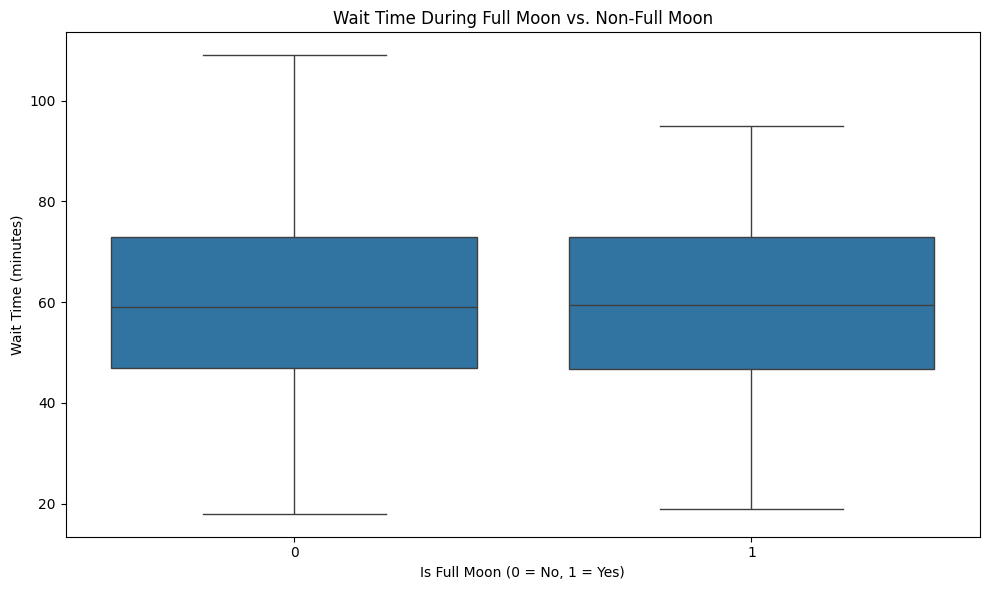

In [89]:
# Plot to visualize the wait times by whether it's a full moon
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_full_moon', y='wait_time_minutes', data=df)
plt.title("Wait Time During Full Moon vs. Non-Full Moon")
plt.xlabel("Is Full Moon (0 = No, 1 = Yes)")
plt.ylabel("Wait Time (minutes)")
plt.tight_layout()
plt.show()

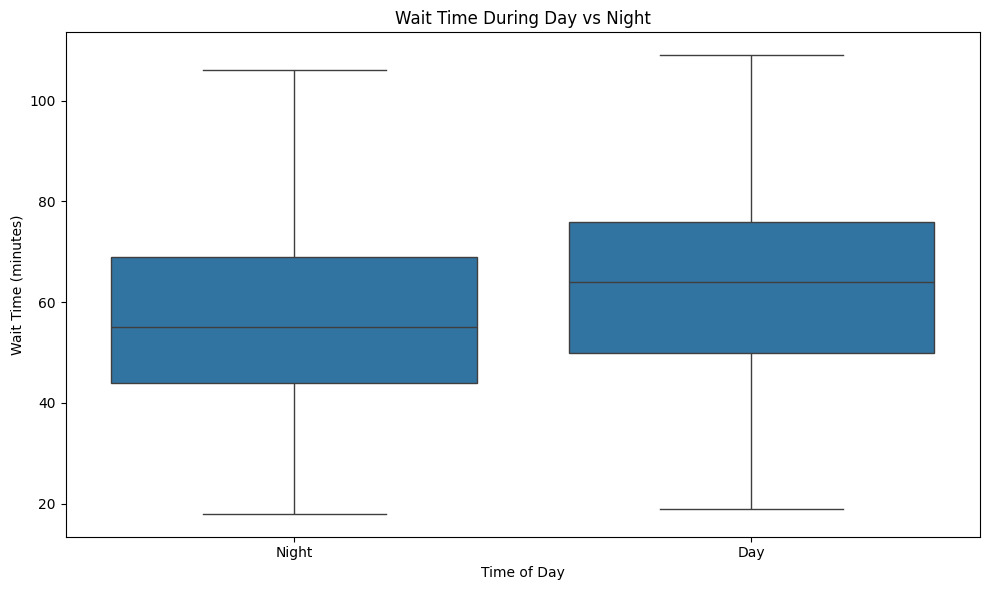

In [90]:
# Plot to visualize the wait times by day or night
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_or_night', y='wait_time_minutes', data=df)
plt.title("Wait Time During Day vs Night")
plt.xlabel("Time of Day")
plt.ylabel("Wait Time (minutes)")
plt.tight_layout()
plt.show()

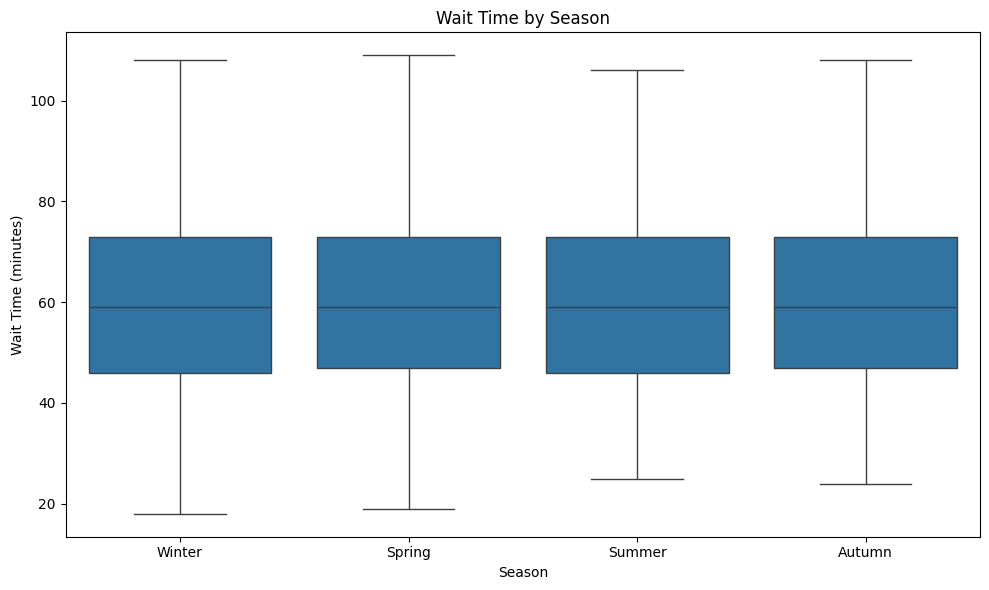

In [91]:
# Visualize Seasonal Impact on Wait Times
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='wait_time_minutes', data=df)
plt.title("Wait Time by Season")
plt.xlabel("Season")
plt.ylabel("Wait Time (minutes)")
plt.tight_layout()
plt.show()

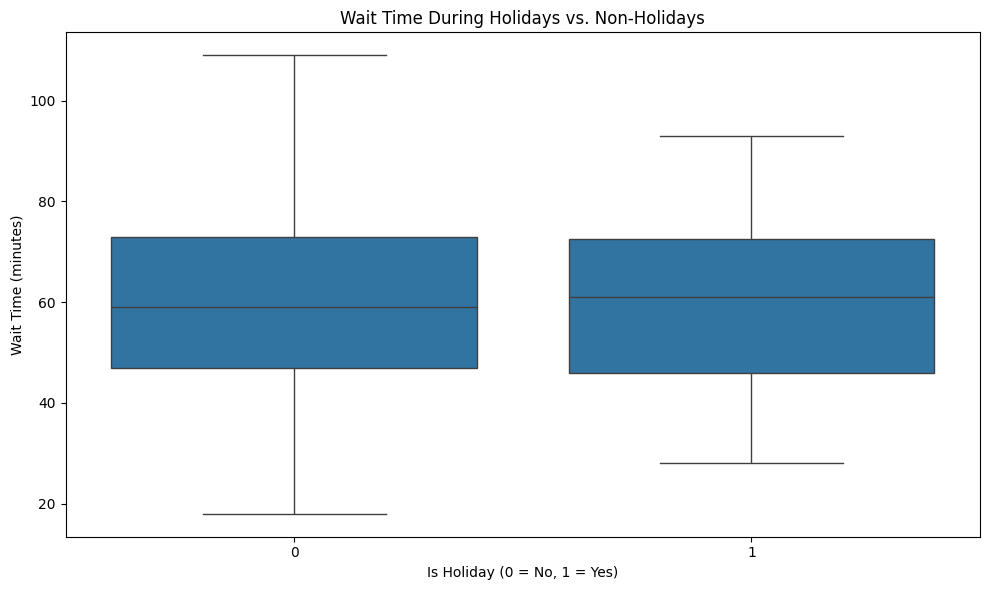

In [92]:
# Visualize Holiday Impact on Wait Times
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_holiday', y='wait_time_minutes', data=df)
plt.title("Wait Time During Holidays vs. Non-Holidays")
plt.xlabel("Is Holiday (0 = No, 1 = Yes)")
plt.ylabel("Wait Time (minutes)")
plt.tight_layout()
plt.show()

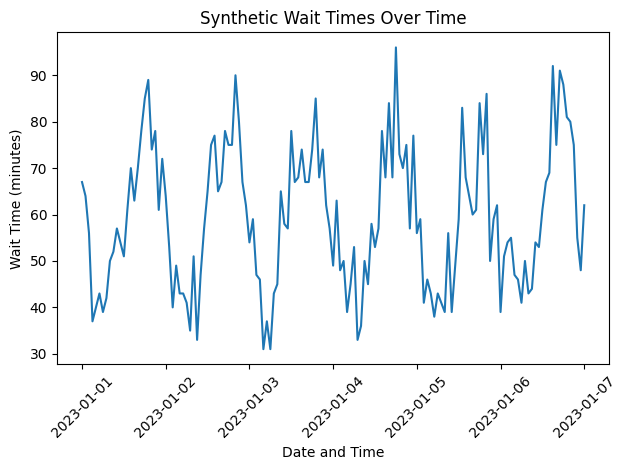

In [55]:
# Plot the synthetic data to see how the wait times fluctuate
sns.lineplot(data=df, x=df.index, y="wait_time_minutes")
plt.title("Synthetic Wait Times Over Time")
plt.xlabel("Date and Time")
plt.ylabel("Wait Time (minutes)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [93]:
# Check the average wait time in the generated data
print("Average Wait Time:", df["wait_time_minutes"].mean())

Average Wait Time: 60.021117917887445


In [94]:
# Step 3.1: T-Test for Full Moon vs Non-Full Moon (using adjusted wait times)
full_moon_wait_times = df[df['is_full_moon'] == 1]['adjusted_wait_time_minutes']
non_full_moon_wait_times = df[df['is_full_moon'] == 0]['adjusted_wait_time_minutes']

t_stat, p_value = ttest_ind(full_moon_wait_times, non_full_moon_wait_times, equal_var=False)
print("T-Test Full Moon vs Non-Full Moon (Adjusted Wait Times):")
print("T-Statistic:", t_stat)
print("P-Value:", p_value)
if p_value < 0.05:
    print("There is a significant difference in adjusted wait times between full moon and non-full moon days.")
else:
    print("There is no significant difference in adjusted wait times between full moon and non-full moon days.")
print("\n")

# Step 3.2: ANOVA for Season Comparison (using adjusted wait times)
winter_wait_times = df[df['season'] == 'Winter']['adjusted_wait_time_minutes']
spring_wait_times = df[df['season'] == 'Spring']['adjusted_wait_time_minutes']
summer_wait_times = df[df['season'] == 'Summer']['adjusted_wait_time_minutes']
autumn_wait_times = df[df['season'] == 'Autumn']['adjusted_wait_time_minutes']

f_stat, p_value = f_oneway(winter_wait_times, spring_wait_times, summer_wait_times, autumn_wait_times)
print("ANOVA Test for Seasons (Adjusted Wait Times):")
print("F-Statistic:", f_stat)
print("P-Value:", p_value)
if p_value < 0.05:
    print("There is a significant difference in adjusted wait times between different seasons.")
else:
    print("There is no significant difference in adjusted wait times between different seasons.")
print("\n")

# Step 3.3: ANOVA for Day vs Night (using adjusted wait times)
day_wait_times = df[df['day_or_night'] == 'Day']['adjusted_wait_time_minutes']
night_wait_times = df[df['day_or_night'] == 'Night']['adjusted_wait_time_minutes']

f_stat, p_value = f_oneway(day_wait_times, night_wait_times)
print("ANOVA Test for Day vs Night (Adjusted Wait Times):")
print("F-Statistic:", f_stat)
print("P-Value:", p_value)
if p_value < 0.05:
    print("There is a significant difference in adjusted wait times between day and night.")
else:
    print("There is no significant difference in adjusted wait times between day and night.")

T-Test Full Moon vs Non-Full Moon (Adjusted Wait Times):
T-Statistic: 0.3509901379854859
P-Value: 0.7258279886072239
There is no significant difference in adjusted wait times between full moon and non-full moon days.


ANOVA Test for Seasons (Adjusted Wait Times):
F-Statistic: 507.79324538946645
P-Value: 8.266e-321
There is a significant difference in adjusted wait times between different seasons.


ANOVA Test for Day vs Night (Adjusted Wait Times):
F-Statistic: 971.9704905571286
P-Value: 1.4601467590177207e-209
There is a significant difference in adjusted wait times between day and night.
